In [1]:
import codecs
import copy
import csv
import gc
import os
import pickle
import random
import time
from typing import Dict, List, Tuple, Union

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
from nltk import wordpunct_tokenize
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.framework import ops, tensor_util
from tensorflow.python.keras.utils import losses_utils, tf_utils
from tensorflow.python.ops import math_ops
from tensorflow.python.ops.losses import util as tf_losses_util
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, XLMRobertaTokenizer
from transformers import TFXLMRobertaModel, XLMRobertaConfig

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
class LossFunctionWrapper(tf.keras.losses.Loss):
    def __init__(self,
                 fn,
                 reduction=losses_utils.ReductionV2.AUTO,
                 name=None,
                 **kwargs):
        super(LossFunctionWrapper, self).__init__(reduction=reduction,
                                                  name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        if tensor_util.is_tensor(y_pred) and tensor_util.is_tensor(y_true):
            y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(
                y_pred, y_true
            )
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = tf.keras.backend.eval(v) \
                if tf_utils.is_tensor_or_variable(v) \
                else v
        base_config = super(LossFunctionWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
def distance_based_log_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    margin = 1.0
    p = (1.0 + tf.math.exp(-margin)) / (1.0 + tf.math.exp(y_pred - margin))
    return tf.keras.backend.binary_crossentropy(target=y_true, output=p)

In [6]:
class DBLLogLoss(LossFunctionWrapper):
    def __init__(self, reduction=losses_utils.ReductionV2.AUTO,
                 name='distance_based_log_loss'):
        super(DBLLogLoss, self).__init__(distance_based_log_loss, name=name,
                                         reduction=reduction)

In [7]:
class AttentionMaskLayer(tf.keras.layers.Layer):
    def __init__(self, pad_token_id: int, **kwargs):
        self.pad_token_id = pad_token_id
        super(AttentionMaskLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionMaskLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return tf.keras.backend.cast(
            x=tf.math.not_equal(
                x=inputs,
                y=self.pad_token_id
            ),
            dtype='int32'
        )

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        return {"pad_token_id": self.pad_token_id}

**def tokenize_all(...)**

This function transforms input texts to token IDs for XLM-RoBERTa. It returns a 2-d numpy array with integer values.

In [8]:
def tokenize_all(texts: List[str], tokenizer: XLMRobertaTokenizer,
                 maxlen: int) -> List[List[int]]:
    if not isinstance(texts, list):
        err_msg = '"{0}" is wrong type for the text list!'.format(type(texts))
        raise ValueError(err_msg)
    n_texts = len(texts)
    all_tokenized_texts = []
    for cur_text in tqdm(texts):
        full_words = wordpunct_tokenize(cur_text)
        sub_words = []
        for cur_word in filter(lambda it2: len(it2) > 0,
                               map(lambda it1: it1.strip(), full_words)):
            bpe = tokenizer.tokenize(cur_word)
            if tokenizer.unk_token in bpe:
                sub_words.append(tokenizer.unk_token)
            else:
                sub_words += bpe
        sub_words = [tokenizer.bos_token] + sub_words + \
                    [tokenizer.eos_token]
        if len(sub_words) > maxlen:
            sub_words = sub_words[:maxlen]
        elif len(sub_words) < maxlen:
            ndiff = maxlen - len(sub_words)
            for _ in range(ndiff):
                sub_words.append(tokenizer.pad_token)
        all_tokenized_texts.append(
            tokenizer.convert_tokens_to_ids(sub_words)
        )
        del sub_words, full_words
    return all_tokenized_texts

**def load_train_set(...)**

This function loads multilingual labeled text corpus for training from the CSV file. If there is no information about language in this CSV file, then I think that all texts language is English.
    
It returns a special dictionary with information about texts and their binary toxicity labels (integer values) by languages (language is a key, and a list of texts and labels is a value).

In [9]:
def load_train_set(file_name: str, text_field: str, sentiment_fields: List[str],
                   lang_field: str) -> Dict[str, List[Tuple[str, int]]]:
    assert len(sentiment_fields) > 0, 'List of sentiment fields is empty!'
    header = []
    line_idx = 1
    data_by_lang = dict()
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        data_reader = csv.reader(fp, quotechar='"', delimiter=',')
        for row in data_reader:
            if len(row) > 0:
                err_msg = 'File "{0}": line {1} is wrong!'.format(file_name, line_idx)
                if len(header) == 0:
                    header = copy.copy(row)
                    err_msg2 = err_msg + ' Field "{0}" is not found!'.format(text_field)
                    assert text_field in header, err_msg2
                    for cur_field in sentiment_fields:
                        err_msg2 = err_msg + ' Field "{0}" is not found!'.format(
                            cur_field)
                        assert cur_field in header, err_msg2
                    text_field_index = header.index(text_field)
                    try:
                        lang_field_index = header.index(lang_field)
                    except:
                        lang_field_index = -1
                    indices_of_sentiment_fields = []
                    for cur_field in sentiment_fields:
                        indices_of_sentiment_fields.append(header.index(cur_field))
                else:
                    if len(row) == len(header):
                        text = row[text_field_index].strip()
                        assert len(text) > 0, err_msg + ' Text is empty!'
                        if lang_field_index >= 0:
                            cur_lang = row[lang_field_index].strip()
                            assert len(cur_lang) > 0, err_msg + ' Language is empty!'
                        else:
                            cur_lang = 'en'
                        max_proba = 0.0
                        for cur_field_idx in indices_of_sentiment_fields:
                            try:
                                cur_proba = float(row[cur_field_idx])
                            except:
                                cur_proba = -1.0
                            err_msg2 = err_msg + ' Value {0} is wrong!'.format(
                                row[cur_field_idx]
                            )
                            assert (cur_proba >= 0.0) and (cur_proba <= 1.0), err_msg2
                            if cur_proba > max_proba:
                                max_proba = cur_proba
                        new_label = 1 if max_proba >= 0.5 else 0
                        if cur_lang not in data_by_lang:
                            data_by_lang[cur_lang] = []
                        data_by_lang[cur_lang].append((text, new_label))
            if line_idx % 10000 == 0:
                print('{0} lines of the "{1}" have been processed...'.format(
                    line_idx, file_name
                ))
            line_idx += 1
    if line_idx > 0:
        if (line_idx - 1) % 10000 != 0:
            print('{0} lines of the "{1}" have been processed...'.format(
                line_idx - 1, file_name
            ))
    return data_by_lang

**def load_test_set(...)**

This function loads multilingual unlabeled text corpus for submission from the CSV file. If there is no information about language in this CSV file, then I think that all texts language is English.
    
It returns a special dictionary with information about texts and their integer identifiers by languages (language is a key, and a list of texts and identifiers is a value).

The function differs from the previous load_train_set only in the expected structure (field set) of the parsed CSV file, and these functions are the same by the structure of returned objects (but special identifiers for submission are used instead of toxicity labels).

In [10]:
def load_test_set(file_name: str, id_field: str, text_field: str,
                  lang_field: str) -> Dict[str, List[Tuple[str, int]]]:
    header = []
    line_idx = 1
    data_by_lang = dict()
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        data_reader = csv.reader(fp, quotechar='"', delimiter=',')
        for row in data_reader:
            if len(row) > 0:
                err_msg = 'File "{0}": line {1} is wrong!'.format(file_name, line_idx)
                if len(header) == 0:
                    header = copy.copy(row)
                    err_msg2 = err_msg + ' Field "{0}" is not found!'.format(text_field)
                    assert text_field in header, err_msg2
                    err_msg2 = err_msg + ' Field "{0}" is not found!'.format(id_field)
                    assert id_field in header, err_msg2
                    err_msg2 = err_msg + ' Field "{0}" is not found!'.format(lang_field)
                    assert lang_field in header, err_msg2
                    id_field_index = header.index(id_field)
                    text_field_index = header.index(text_field)
                    lang_field_index = header.index(lang_field)
                else:
                    if len(row) == len(header):
                        try:
                            id_value = int(row[id_field_index])
                        except:
                            id_value = -1
                        err_msg2 = err_msg + ' {0} is wrong ID!'.format(
                            row[id_field_index])
                        assert id_value >= 0, err_msg2
                        text = row[text_field_index].strip()
                        assert len(text) > 0, err_msg + ' Text is empty!'
                        if lang_field_index >= 0:
                            cur_lang = row[lang_field_index].strip()
                            assert len(cur_lang) > 0, err_msg + ' Language is empty!'
                        else:
                            cur_lang = 'en'
                        if cur_lang not in data_by_lang:
                            data_by_lang[cur_lang] = []
                        data_by_lang[cur_lang].append((text, id_value))
            if line_idx % 10000 == 0:
                print('{0} lines of the "{1}" have been processed...'.format(
                    line_idx, file_name
                ))
            line_idx += 1
    if line_idx > 0:
        if (line_idx - 1) % 10000 != 0:
            print('{0} lines of the "{1}" have been processed...'.format(
                line_idx - 1, file_name
            ))
    return data_by_lang

**def generate_text_probabilities(...)**

This function generates probabilities of text This function generates probabilities of each text random selection from list of all texts. Selection probability is the greater, the shorter the corresponded text.

In [11]:
def generate_text_probabilities(source_texts: List[Tuple[str, int]],
                                interesting_indices: List[int]) -> np.ndarray:
    lengths_of_texts = []
    max_chars_number = 0
    for idx in interesting_indices:
        cur_chars_number = len(source_texts[idx][0])
        lengths_of_texts.append(cur_chars_number)
        if cur_chars_number > max_chars_number:
            max_chars_number = cur_chars_number
    assert max_chars_number > 100
    probabilities = np.zeros((len(lengths_of_texts),), dtype=np.float64)
    counter = 0
    for idx, val in enumerate(lengths_of_texts):
        if val > 10:
            probabilities[idx] = max_chars_number * 10 - val
        else:
            counter += 1
    assert counter == 0
    probabilities /= np.sum(probabilities)
    min_proba = 0.5 / float(probabilities.shape[0])
    for idx in range(probabilities.shape[0]):
        if probabilities[idx] > 0.0:
            if probabilities[idx] < min_proba:
                probabilities[idx] = min_proba
    return probabilities / np.sum(probabilities)

**def build_siamese_dataset(...)**

This function transforms a labeled text corpus in format, which is like to result of the *load_train_set* function, into a special Tensorflow dataset with considering of specified mini-batch size. Also, it returns the total number of mini-batches in this dataset.

In [12]:
def build_siamese_dataset(texts: Dict[str, List[Tuple[str, int]]],
                          dataset_size: int, tokenizer: XLMRobertaTokenizer,
                          maxlen: int, batch_size: int,
                          shuffle: bool) -> Tuple[tf.data.Dataset, int]:
    language_pairs = set()
    for language in texts.keys():
        for other_language in texts:
            if other_language == language:
                language_pairs.add((language, other_language))
            else:
                pair_1 = (language, other_language)
                pair_2 = (other_language, language)
                if (pair_1 not in language_pairs) and (pair_2 not in language_pairs):
                    language_pairs.add(pair_1)
    language_pairs = sorted(list(language_pairs))
    print('Possible language pairs are: {0}.'.format(language_pairs))
    err_msg = '{0} is too small size of the data set!'.format(dataset_size)
    assert dataset_size >= (len(language_pairs) * 10), err_msg
    n_samples_for_lang_pair = int(np.ceil(dataset_size / float(len(language_pairs))))
    text_pairs_and_labels = []
    for left_lang, right_lang in language_pairs:
        print('{0}-{1}:'.format(left_lang, right_lang))
        left_positive_indices = list(filter(
            lambda idx: ((texts[left_lang][idx][1] > 0) and \
                         (len(texts[left_lang][idx][0]) > 10)),
            range(len(texts[left_lang]))
        ))
        left_positive_probas = generate_text_probabilities(
            source_texts=texts[left_lang],
            interesting_indices=left_positive_indices
        )
        left_negative_indices = list(filter(
            lambda idx: ((texts[left_lang][idx][1] == 0) and \
                         (len(texts[left_lang][idx][0]) > 10)),
            range(len(texts[left_lang]))
        ))
        left_negative_probas = generate_text_probabilities(
            source_texts=texts[left_lang],
            interesting_indices=left_negative_indices
        )
        right_positive_indices = list(filter(
            lambda idx: ((texts[right_lang][idx][1] > 0) and \
                         (len(texts[right_lang][idx][0]) > 10)),
            range(len(texts[right_lang]))
        ))
        right_positive_probas = generate_text_probabilities(
            source_texts=texts[right_lang],
            interesting_indices=right_positive_indices
        )
        right_negative_indices = list(filter(
            lambda idx: ((texts[right_lang][idx][1] == 0) and \
                         (len(texts[right_lang][idx][0]) > 10)),
            range(len(texts[right_lang]))
        ))
        right_negative_probas = generate_text_probabilities(
            source_texts=texts[right_lang],
            interesting_indices=right_negative_indices
        )
        used_pairs = set()
        number_of_samples = 0
        iterations = n_samples_for_lang_pair // 4
        if len(left_positive_indices) > iterations:
            left_indices = np.random.choice(
                left_positive_indices,
                min(iterations * 2, len(left_positive_indices)),
                p=left_positive_probas, replace=False
            ).tolist()
        else:
            left_indices = left_positive_indices
        if len(right_positive_indices) > iterations:
            right_indices = np.random.choice(
                right_positive_indices,
                min(iterations * 2, len(right_positive_indices)),
                p=right_positive_probas, replace=False
            ).tolist()
        else:
            right_indices = right_positive_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]
        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            text_pairs_and_labels.append(
                (
                    texts[left_lang][left_idx][0],
                    texts[right_lang][right_idx][0],
                    1
                )
            )
            number_of_samples += 1
            if number_of_samples >= iterations:
                break
        del left_indices, right_indices
        print('  number of "1-1" pairs is {0};'.format(number_of_samples))
        number_of_samples = 0
        iterations = (2 * n_samples_for_lang_pair) // 4
        iterations -= n_samples_for_lang_pair // 4
        if len(left_negative_indices) > iterations:
            left_indices = np.random.choice(
                left_negative_indices,
                min(iterations * 2, len(left_negative_indices)),
                p=left_negative_probas, replace=False
            ).tolist()
        else:
            left_indices = left_negative_indices
        if len(right_negative_indices) > iterations:
            right_indices = np.random.choice(
                right_negative_indices,
                min(iterations * 2, len(right_negative_indices)),
                p=right_negative_probas, replace=False
            ).tolist()
        else:
            right_indices = right_negative_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]
        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            text_pairs_and_labels.append(
                (
                    texts[left_lang][left_idx][0],
                    texts[right_lang][right_idx][0],
                    1
                )
            )
            number_of_samples += 1
            if number_of_samples >= iterations:
                break
        del left_indices, right_indices
        print('  number of "0-0" pairs is {0};'.format(number_of_samples))
        number_of_samples = 0
        iterations = n_samples_for_lang_pair
        iterations -= (2 * n_samples_for_lang_pair) // 4
        if len(left_negative_indices) > iterations:
            left_indices = np.random.choice(
                left_negative_indices,
                min(iterations * 2, len(left_negative_indices)),
                p=left_negative_probas, replace=False
            ).tolist()
        else:
            left_indices = left_negative_indices
        if len(right_positive_indices) > iterations:
            right_indices = np.random.choice(
                right_positive_indices,
                min(iterations * 2, len(right_positive_indices)),
                p=right_positive_probas, replace=False
            ).tolist()
        else:
            right_indices = right_positive_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]
        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            if random.random() >= 0.5:
                text_pairs_and_labels.append(
                    (
                        texts[left_lang][left_idx][0],
                        texts[right_lang][right_idx][0],
                        0
                    )
                )
            else:
                text_pairs_and_labels.append(
                    (
                        texts[right_lang][right_idx][0],
                        texts[left_lang][left_idx][0],
                        0
                    )
                )
            number_of_samples += 1
            if number_of_samples >= iterations:
                break
        del left_indices, right_indices
        print('  number of "0-1" or "1-0" pairs is {0}.'.format(
            number_of_samples
        ))
    random.shuffle(text_pairs_and_labels)
    n_steps = len(text_pairs_and_labels) // batch_size
    print('Samples number of the data set is {0}.'.format(
        len(text_pairs_and_labels)
    ))
    print('Samples number per each language pair is {0}.'.format(
        n_samples_for_lang_pair
    ))
    tokens_of_left_texts = tokenize_all(
        texts=[cur[0] for cur in text_pairs_and_labels],
        tokenizer=tokenizer, maxlen=maxlen
    )
    tokens_of_left_texts = np.array(tokens_of_left_texts, dtype=np.int32)
    print('')
    print('3 examples of left texts after tokenization:')
    for _ in range(3):
        idx = random.randint(0, len(text_pairs_and_labels) - 1)
        print('  {0}'.format(text_pairs_and_labels[idx][0]))
        print('  {0}'.format(tokens_of_left_texts[idx].tolist()))
        print('')
    tokens_of_right_texts = tokenize_all(
        texts=[cur[1] for cur in text_pairs_and_labels],
        tokenizer=tokenizer, maxlen=maxlen
    )
    tokens_of_right_texts = np.array(tokens_of_right_texts, dtype=np.int32)
    print('3 examples of right texts after tokenization:')
    for _ in range(3):
        idx = random.randint(0, len(text_pairs_and_labels) - 1)
        print('  {0}'.format(text_pairs_and_labels[idx][1]))
        print('  {0}'.format(tokens_of_right_texts[idx].tolist()))
        print('')
    siamese_labels = np.array([cur[2] for cur in text_pairs_and_labels],
                              dtype=np.int32)
    print('Number of positive siamese samples is {0} from {1}.'.format(
        int(sum(siamese_labels)), siamese_labels.shape[0]))
    err_msg = '{0} != 2'.format(len(tokens_of_left_texts.shape))
    assert len(tokens_of_left_texts.shape) == 2, err_msg
    err_msg = '{0} != 1'.format(len(siamese_labels.shape))
    assert len(siamese_labels.shape) == 1, err_msg
    err_msg = '{0} != {1}'.format(tokens_of_left_texts.shape, tokens_of_right_texts.shape)
    assert tokens_of_left_texts.shape == tokens_of_right_texts.shape, err_msg
    err_msg = '{0} != {1}'.format(tokens_of_left_texts.shape[0], siamese_labels.shape[0])
    assert tokens_of_left_texts.shape[0] == siamese_labels.shape[0], err_msg
    if shuffle:
        err_msg = '{0} is too small number of samples for the data set!'.format(
            len(text_pairs_and_labels))
        assert n_steps >= 50, err_msg
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                (
                    tokens_of_left_texts,
                    tokens_of_right_texts
                ),
                siamese_labels
            )
        ).repeat().batch(batch_size)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                (
                    tokens_of_left_texts,
                    tokens_of_right_texts
                ),
                siamese_labels
            )
        ).batch(batch_size)
    del text_pairs_and_labels
    return dataset, n_steps

**def build_feature_extractor(...)**

This function builds a sentence embedder, based on XLM-RoBERTa, as a Keras model.

In [13]:
def build_feature_extractor(transformer_name: str, padding: int,
                            max_len: int) -> tf.keras.Model:
    xlmroberta_config = XLMRobertaConfig.from_pretrained(transformer_name)
    max_position_embeddings = xlmroberta_config.max_position_embeddings
    if max_len > (max_position_embeddings - 2):
        err_msg = 'max_text_len = {0} is too large! It must be less ' \
                  'then {1}.'.format(max_text_len, max_position_embeddings - 1)
        raise ValueError(err_msg)
    output_embedding_size = xlmroberta_config.hidden_size
    word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                     name="base_word_ids_FE")
    attention_mask = AttentionMaskLayer(
        pad_token_id=padding, name='base_attention_mask_FE',
        trainable=False
    )(word_ids)
    del xlmroberta_config
    transformer_layer = TFXLMRobertaModel.from_pretrained(
        pretrained_model_name_or_path=transformer_name,
        name='Transformer'
    )
    sequence_output = transformer_layer(
        [word_ids, attention_mask]
    )[0]
    output_mask = tf.cast(attention_mask, dtype=tf.bool)
    pooled_output = tf.keras.layers.GlobalAvgPool1D(
        name='AvePool_FE'
    )(sequence_output, mask=output_mask)
    text_embedding = tf.keras.layers.LayerNormalization(
        name='Emdedding_FE'
    )(pooled_output)
    fe_model = tf.keras.Model(
        inputs=word_ids,
        outputs=text_embedding,
        name='FeatureExtractor'
    )
    fe_model.build(input_shape=(None, max_len))
    return fe_model

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.keras.backend.sum(tf.keras.backend.square(x - y),
                                      axis=1, keepdims=True)
    return tf.keras.backend.sqrt(
        tf.keras.backend.maximum(sum_square, tf.keras.backend.epsilon())
    )

In [15]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

**def build_siamese_nn(...)**

This function builds a Siamese neural network, which consists of two XLM-RoBERTa sentence embedders with shared weights (the XLM-RoBERTa sentence embedder is created using the *build_feature_extractor* function), a Euclidean distance layer, and a distance-based logistic loss.

When I compile my *tf.keras.Model* object, then I set an [Adam](https://arxiv.org/abs/1711.05101) algorithm as optimizer with .

In [16]:
def build_siamese_nn(transformer_name: str, max_len: int, padding: int,
                     stepsize: int) -> Tuple[tf.keras.Model, tf.keras.Model]:
    left_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                          name="left_word_ids")
    right_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,
                                           name="right_word_ids")
    fe_ = build_feature_extractor(
        transformer_name=transformer_name,
        padding=padding,
        max_len=max_len
    )
    left_text_embedding = fe_(left_word_ids)
    right_text_embedding = fe_(right_word_ids)
    distance_layer = tf.keras.layers.Lambda(
        function=euclidean_distance,
        output_shape=eucl_dist_output_shape,
        name='L2DistLayer'
    )([left_text_embedding, right_text_embedding])
    nn = tf.keras.Model(
        inputs=[left_word_ids, right_word_ids],
        outputs=distance_layer,
        name='SiameseXLMR'
    )
    lr_schedule = tfa.optimizers.Triangular2CyclicalLearningRate(
        initial_learning_rate=1e-6,
        maximal_learning_rate=5e-5,
        step_size=3 * stepsize
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    nn.compile(
        optimizer=optimizer,
        loss=DBLLogLoss()
    )
    fe_.summary()
    print('')
    nn.summary()
    return nn, fe_

**def show_training_process(...)**

This function shows a training metric curve and a validation one using a Tensorflow log (i.e. the *tf.keras.callbacks.History* object). A kind of metric (loss, accuracy, or any other measure) is specified by the additional parameter *metric_name*.

In [17]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1):
    val_metric_name = 'val_' + metric_name
    err_msg = 'The metric "{0}" is not found! Available metrics are: {1}'.format(
        metric_name, list(history.history.keys()))
    assert metric_name in history.history, err_msg
    plt.figure(figure_id, figsize=(5, 5))
    plt.plot(list(range(len(history.history[metric_name]))),
             history.history[metric_name], label='Training {0}'.format(metric_name))
    if val_metric_name in history.history:
        assert len(history.history[metric_name]) == len(history.history['val_' + metric_name])
        plt.plot(list(range(len(history.history['val_' + metric_name]))),
                 history.history['val_' + metric_name], label='Validation {0}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

**def train_siamese_nn(...)**

This function applies a training procedure to a specified Siamese neural network. Two stopping criteria are used at the same time: 1) "classical" early stopping criterion; 2) stopping by exceeding of maximal training duration (in seconds). The best weights of the neural network, which correspond to training moment with a minimal value of validation loss, are saved in the special binary file *model_weights_path*.

In [18]:
def train_siamese_nn(nn: tf.keras.Model, trainset: tf.data.Dataset, steps_per_trainset: int,
                     steps_per_epoch: int, validset: tf.data.Dataset, max_duration: int,
                     model_weights_path: str):
    assert steps_per_trainset >= steps_per_epoch
    n_epochs = max(30, int(round(10.0 * steps_per_trainset / float(steps_per_epoch))))
    print('Maximal duration of the Siamese XLM-R training is {0} '\
          'seconds.'.format(max_duration))
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=9, monitor='val_loss', mode='min',
                                         restore_best_weights=False, verbose=True),
        tf.keras.callbacks.ModelCheckpoint(model_weights_path, monitor='val_loss',
                                           mode='min', save_best_only=True,
                                           save_weights_only=True, verbose=True),
        tfa.callbacks.TimeStopping(seconds=max_duration, verbose=True)
    ]
    history = nn.fit(
        trainset,
        steps_per_epoch=steps_per_epoch,
        validation_data=validset,
        epochs=n_epochs,
        callbacks=callbacks
    )
    show_training_process(history, 'loss')

**def calculate_features_of_texts(...)**

This function calculates sentence embeddings (i.e. fixed-size semantic vectors for sentences) using a trained XLM-RoBERTa-based feature extractor. Input texts with their toxicity labels (or integer identifiers instead of labels) are specified in a format which is like as a result format of the *load_train_set* and the *load_test_set* functions.

The returned object is a dictionary, where a key is a language and a value is a tuple consists of two NumPy arrays (the first of them is a matrix of sentence vectors, and the second of them is a 1d-array of integer labels or identifiers).

In [19]:
def calculate_features_of_texts(texts: Dict[str, List[Tuple[str, int]]],
                                tokenizer: XLMRobertaTokenizer, maxlen: int,
                                fe: tf.keras.Model, batch_size: int,
                                max_dataset_size: int = 0) -> \
        Tuple[Dict[str, Tuple[np.ndarray, np.ndarray]]]:
    languages = sorted(list(texts.keys()))
    datasets_by_languages = dict()
    if max_dataset_size > 0:
        max_size_per_lang = max_dataset_size // len(languages)
        err_msg = '{0} is too small number of dataset samples!'.format(max_dataset_size)
        assert max_size_per_lang > 0, err_msg
    else:
        max_size_per_lang = 0
    print('Number of languages is {0}.'.format(len(texts)))
    for cur_lang in languages:
        print('')
        print('Language "{0}": featurizing is started.'.format(cur_lang))
        selected_indices = list(range(len(texts[cur_lang])))
        print('Number of texts is {0}.'.format(len(selected_indices)))
        if max_size_per_lang > 0:
            if len(selected_indices) > max_size_per_lang:
                selected_indices = random.sample(
                    population=selected_indices,
                    k=max_size_per_lang
                )
        tokens_of_texts = tokenize_all(
            texts=[texts[cur_lang][idx][0] for idx in selected_indices],
            tokenizer=tokenizer, maxlen=maxlen
        )
        tokens_of_texts = np.array(tokens_of_texts, dtype=np.int32)
        print('')
        print('3 examples of texts after tokenization:')
        for _ in range(3):
            idx = random.randint(0, len(selected_indices) - 1)
            print('  {0}'.format(texts[cur_lang][selected_indices[idx]][0]))
            print('  {0}'.format(tokens_of_texts[idx].tolist()))
            print('')
        X = []
        n_batches = int(np.ceil(len(selected_indices) / float(batch_size)))
        if n_batches >= 10:
            n_data_parts = 10
            data_part_size = int(np.ceil(n_batches / float(n_data_parts)))
        else:
            n_data_parts = 0
        data_part_counter = 0
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(len(selected_indices), batch_start + batch_size)
            res = fe.predict_on_batch(tokens_of_texts[batch_start:batch_end])
            if not isinstance(res, np.ndarray):
                res = res.numpy()
            X.append(res)
            del res
            if n_data_parts > 0:
                if (batch_idx + 1) % data_part_size == 0:
                    data_part_counter += 1
                    print('  {0}% of texts are featured.'.format(data_part_counter * 10))
        if (n_data_parts > 0) and (data_part_counter < n_data_parts):
            print('  100% of texts are featured.')
        X = np.vstack(X)
        y = np.array([texts[cur_lang][idx][1] for idx in selected_indices], dtype=np.int32)
        datasets_by_languages[cur_lang] = (X, y)
        del X, y, selected_indices
        print('Language "{0}": featurizing is finished.'.format(cur_lang))
    return datasets_by_languages

**def generate_featured_data(...)**

This function prepares all generated feature vectors for training and submission in a form that is more comfortable for future experiments with various classifiers in the new feature space. The result of the function is a 3-element tuple:

1. training data as two NumPy arrays: matrix of feature vectors for the training of a final classifier and vector of corresponded toxicity labels;
2. splitting of training data by languages as a dictionary of train/test indices by language name (so, one cross-validation fold corresponds to one language);
3. data for submitting as two NumPy arrays: matrix of feature vectors as inputs for the final classifier and vector of corresponded submission samples identifiers.

In [20]:
def generate_featured_data(
    features_by_lang: Dict[str, Tuple[np.ndarray, np.ndarray]],
    features_for_submission: Union[Dict[str, Tuple[np.ndarray, np.ndarray]], None] = None,
) -> Tuple[Tuple[np.ndarray, np.ndarray], Dict[str, Tuple[np.ndarray, np.ndarray]], \
           Union[Tuple[np.ndarray, np.ndarray]], None]:
    X_embedded = []
    y_embedded = []
    split_by_languages = dict()
    start_pos = 0
    for cur_lang in features_by_lang:
        X_embedded.append(features_by_lang[cur_lang][0])
        y_embedded.append(features_by_lang[cur_lang][1])
        split_by_languages[cur_lang] = (
            set(),
            set(range(start_pos, start_pos + features_by_lang[cur_lang][1].shape[0]))
        )
        start_pos = start_pos + features_by_lang[cur_lang][1].shape[0]
    featured_data_for_training = (
        np.vstack(X_embedded),
        np.concatenate(y_embedded)
    )
    del X_embedded, y_embedded
    err_msg = '{0} != {1}'.format(featured_data_for_training[0].shape[0],
                                  featured_data_for_training[1].shape[0])
    assert featured_data_for_training[0].shape[0] == featured_data_for_training[1].shape[0], err_msg
    for cur_lang in features_by_lang:
        indices_for_testing = split_by_languages[cur_lang][1]
        indices_for_training = set(range(featured_data_for_training[0].shape[0]))
        indices_for_training -= indices_for_testing
        split_by_languages[cur_lang] = (
            np.array(sorted(list(indices_for_training)), dtype=np.int32),
            np.array(sorted(list(indices_for_testing)), dtype=np.int32)
        )
        del indices_for_training, indices_for_testing
    all_languages = sorted(list(split_by_languages.keys()))
    prev_lang = all_languages[0]
    assert len(set(split_by_languages[prev_lang][1].tolist()) & \
               set(split_by_languages[prev_lang][0].tolist())) == 0
    for cur_lang in all_languages[1:]:
        assert len(set(split_by_languages[cur_lang][1].tolist()) & \
                   set(split_by_languages[cur_lang][0].tolist())) == 0
        assert len(set(split_by_languages[cur_lang][1].tolist()) & \
                   set(split_by_languages[prev_lang][1].tolist())) == 0
        prev_lang = cur_lang
    if features_for_submission is None:
        return featured_data_for_training, split_by_languages
    featured_inputs_for_submission = []
    identifies_for_submission = []
    for cur_lang in features_for_submission:
        featured_inputs_for_submission.append(features_for_submission[cur_lang][0])
        identifies_for_submission.append(features_for_submission[cur_lang][1])
    featured_data_for_submission = (
        np.vstack(featured_inputs_for_submission),
        np.concatenate(identifies_for_submission)
    )
    del featured_inputs_for_submission, identifies_for_submission
    n_samples_for_submission = featured_data_for_submission[0].shape[0]
    n_IDs_for_submission = featured_data_for_submission[1].shape[0]
    err_msg = '{0} != {1}'.format(n_samples_for_submission, n_IDs_for_submission)
    assert n_samples_for_submission == n_IDs_for_submission, err_msg
    return (featured_data_for_training, split_by_languages, featured_data_for_submission)

**def calculate_projections(...)**

This function is needed to calculate T-SNE projections of labeled data and their visualization on the 2d space.

In [21]:
def calculate_projections(labeled_data: Tuple[np.ndarray, np.ndarray],
                          additional_title: str):
    X_prj = labeled_data[0]
    y_prj = labeled_data[1]
    assert len(X_prj.shape) == 2
    assert len(y_prj.shape) == 1
    n_samples = X_prj.shape[0]
    err_msg = '{0} != {1}'.format(n_samples, y_prj.shape[0])
    assert n_samples == y_prj.shape[0], err_msg
    if n_samples > 3000:
        test_size = 1500.0 / float(n_samples)
        _, X_prj, _, y_prj = train_test_split(X_prj, y_prj, test_size=test_size,
                                              random_state=42, stratify=y_prj)
    X_prj = TSNE(n_components=2, n_jobs=-1).fit_transform(X_prj)
    plt.figure(figsize=(10, 10))
    indices_of_negative_classes = list(filter(
        lambda sample_idx: y_prj[sample_idx] == 0,
        range(y_prj.shape[0])
    ))
    xy = X_prj[indices_of_negative_classes]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color='g', markersize=4,
             label='Normal texts')
    indices_of_positive_classes = list(filter(
        lambda sample_idx: y_prj[sample_idx] > 0,
        range(y_prj.shape[0])
    ))
    xy = X_prj[indices_of_positive_classes]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color='r', markersize=6,
             label='Toxic texts')
    if len(additional_title) > 0:
        if additional_title[0].isalnum():
            plt.title('Toxic and normal texts {0}'.format(additional_title))
        else:
            plt.title('Toxic and normal texts{0}'.format(additional_title))
    else:
        plt.title('Toxic and normal texts')
    plt.legend(loc='best')
    plt.show()

# Declaration of all functions is finished, and now I start to write the main code

I fix start time moment of experiments

In [22]:
experiment_start_time = time.time()

I detect a hardware for my experiments (GPU or TPU) and create a corresponded [distribution strategy](https://www.tensorflow.org/guide/distributed_training) as a special Tensorflow object.

In [23]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    physical_devices = tf.config.list_physical_devices('GPU')
    for device_idx in range(strategy.num_replicas_in_sync):
        tf.config.experimental.set_memory_growth(physical_devices[device_idx], True)
model_name = 'jplu/tf-xlm-roberta-base'
max_seq_len = 128
batch_size_for_siamese = 32 * strategy.num_replicas_in_sync
print("REPLICAS: ", strategy.num_replicas_in_sync)
print('Model name: {0}'.format(model_name))
print('Maximal length of sequence is {0}'.format(max_seq_len))
print('Batch size for the Siamese XLM-RoBERTa is {0}'.format(
    batch_size_for_siamese))

REPLICAS:  1
Model name: jplu/tf-xlm-roberta-base
Maximal length of sequence is 128
Batch size for the Siamese XLM-RoBERTa is 32


I initialize a seed for all pseudo-random generators. This thing is very important for an experiment reproducibility!

In [24]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

I set all file paths to the input data and to all generated results, i.e. trained Siamese XLM-R and featured data for competition, calculated using this model.

In [25]:
dataset_dir = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification'
tmp_roberta_name = '/kaggle/working/siamese_xlmr.h5'
feature_extractor_name = '/kaggle/working/xlmr_fe.h5'
tmp_features_name = '/kaggle/working/features_by_siamese_xlmr.pkl'

I download meta-information about selected XLM-R from the Hugginface Transformers, and I prepare the configuration and tokenizer accordingly to this meta-information.

In [26]:
xlmroberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
xlmroberta_config = XLMRobertaConfig.from_pretrained(model_name)
print(xlmroberta_config)
print('xlmroberta_tokenizer.pad_token_id',
      xlmroberta_tokenizer.pad_token_id)


XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

xlmroberta_tokenizer.pad_token_id 1


I detect a sentence embedding size from the XLM-R configuration, and I check a maximal length of token sequence accordingly to this configuration.

In [27]:
sentence_embedding_size = xlmroberta_config.hidden_size
print('Sentence embedding size is {0}'.format(sentence_embedding_size))
assert max_seq_len <= xlmroberta_config.max_position_embeddings

Sentence embedding size is 768


I load data for training. These data must contain labeled English texts.

In [28]:
corpus_for_training = load_train_set(
    os.path.join(dataset_dir, "jigsaw-unintended-bias-train.csv"),
    text_field="comment_text", lang_field="lang",
    sentiment_fields=["toxic", "severe_toxicity", "obscene", "identity_attack",
                      "insult", "threat"]
)
assert 'en' in corpus_for_training

10000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
20000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
30000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
40000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
50000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
60000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
70000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv" have been processed...
80000 lines of the "

I load multilingual data for training in addition to the abovementioned English data. These data must represent texts in three languages (non-English only)

In [29]:
multilingual_corpus = load_train_set(
    os.path.join(dataset_dir, "validation.csv"),
    text_field="comment_text", lang_field="lang", sentiment_fields=["toxic", ]
)
assert 'en' not in multilingual_corpus
max_size = 0
print('Multilingual data:')
for language in sorted(list(multilingual_corpus.keys())):
    print('  {0}\t\t{1} samples'.format(language, len(multilingual_corpus[language])))
    assert set(map(lambda cur: cur[1], multilingual_corpus[language])) == {0, 1}
    if len(multilingual_corpus[language]) > max_size:
        max_size = len(multilingual_corpus[language])

8001 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv" have been processed...
Multilingual data:
  es		2500 samples
  it		2500 samples
  tr		3000 samples


I split the text corpus in English into three parts. The first part will rich the multilingual corpus for training (as the fourth language). The second part will be used as a data source for a Siamese network validation to implement early stopping. Finally, the third part, which is the largest, will be used as a data source for the training set of a Siamese network.

In [30]:
err_msg = 'Size of English corpus = {0} is too small!'.format(
    len(corpus_for_training['en'])
)
assert len(corpus_for_training['en']) >= (max_size * 10), err_msg
random.shuffle(corpus_for_training['en'])
multilingual_corpus['en'] = corpus_for_training['en'][:max_size]
n_validation = int(round(0.1 * (len(corpus_for_training['en']) - max_size)))
corpus_for_validation = {'en': corpus_for_training['en'][max_size:(max_size + n_validation)]}
corpus_for_training = {'en': corpus_for_training['en'][(n_validation + max_size):]}

I load multilingual data for final toxicity classification and submitting to the competition.

In [31]:
texts_for_submission = load_test_set(
    os.path.join(dataset_dir, "test.csv"),
    text_field="content", lang_field="lang", id_field="id"
)
print('Data for submission:')
for language in sorted(list(texts_for_submission.keys())):
    print('  {0}\t\t{1} samples'.format(language, len(texts_for_submission[language])))

10000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
20000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
30000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
40000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
50000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
60000 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
63813 lines of the "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv" have been processed...
Data for submission:
  es		8438 samples
  fr		10920 samples
  it		8494 samples
  pt		11012 samples
  ru		10948 samples
  tr		14000 samples


I prepare a dataset for the Siamese XLM-R training (the number of labeled pairs in this dataset is equal to 500000).

In [32]:
dataset_for_training, n_batches_per_data = build_siamese_dataset(
    texts=corpus_for_training, dataset_size=500000,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    batch_size=batch_size_for_siamese, shuffle=True
)

Possible language pairs are: [('en', 'en')].
en-en:
  number of "1-1" pairs is 125000;
  number of "0-0" pairs is 125000;
  number of "0-1" or "1-0" pairs is 139561.
Samples number of the data set is 389561.
Samples number per each language pair is 500000.




3 examples of left texts after tokenization:
  great.  now they have the chance to play more 6'2" 245 lbs dudes against 300 lbs like washington gets to play.  And it is a sad state of affairs when you have thugs, criminals and gangsters on your team and you are still mediocre.
  [0, 6782, 6, 5, 5036, 1836, 765, 70, 18227, 47, 11301, 1286, 305, 242, 116, 44, 122416, 96, 16145, 115, 988, 26548, 2668, 96, 16145, 1884, 509, 127, 42562, 62163, 47, 11301, 6, 5, 3493, 442, 83, 10, 17110, 11341, 111, 103086, 7, 3229, 398, 765, 68180, 7, 6, 4, 49602, 7, 136, 4642, 37499, 98, 935, 7175, 136, 398, 621, 7464, 8738, 7612, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  This is coming from the same guy that said if he considered it a bad law he would have no problem breaking it?  Smells like a Hypocrite to me.
  [0, 3293, 83, 38162, 1295, 70, 5701, 4894


3 examples of right texts after tokenization:
  Trump is only responsible for what he actually said, not how you understood and interpreted what he said. Trump never asked Russia to actively hack Hillary's emails, however that is exactly what the far left refuses to accept.
  [0, 5879, 83, 4734, 102778, 100, 2367, 764, 20653, 2804, 6, 4, 959, 3642, 398, 217064, 136, 29481, 297, 2367, 764, 2804, 6, 5, 5879, 8306, 37170, 49002, 47, 36457, 538, 85526, 124830, 242, 91, 3340, 7, 6, 4, 49903, 450, 83, 66161, 2367, 70, 2060, 25737, 128120, 7, 47, 26946, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  i don't think we must talk down this prison..... it will nicely accommodate most of Zuma's family and his Executive, the Guptas, Singh, Molefe, Abrahams, Monyane and more..... and its location, ideal for the Zulu

I prepare a dataset for the Siamese XLM-R validation during training (the number of labeled pairs in this dataset is equal to 1000).

In [33]:
dataset_for_validation, n_batches_per_epoch = build_siamese_dataset(
    texts=corpus_for_validation, dataset_size=1000,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    batch_size=batch_size_for_siamese, shuffle=False
)

Possible language pairs are: [('en', 'en')].
en-en:
  number of "1-1" pairs is 250;
  number of "0-0" pairs is 250;
  number of "0-1" or "1-0" pairs is 500.
Samples number of the data set is 1000.
Samples number per each language pair is 1000.




3 examples of left texts after tokenization:
  AlwaysThere: I appreciate that you offer your ideas. I do wonder if some religious people think they are their ideas or ideas as God has spoken to them. Where do your thoughts come from?
First, "God is the creator of morality". I am not sure all Christians think that, but then some would say, they are not Christians. That seems circular. But the main point is the notion that God has a corner on right and wrong. This gets into free will. 
As far as society falling into nihilism and chaos as we see now, people have been saying that for centuries. I guess one could say we are always falling, but we seem to get back up. 
It appears you are questioning the legitimacy of Gary's comment about Trump as just opinion. But maybe God spoke to him in God's own way. 
The last part about never having access to truth unless one is born of the spirit is veiled superiority, which I am not attacking. But I believe that we are given the gift of reason, whic


3 examples of right texts after tokenization:
  Dion has strength and moxy and integrity and the courage of his principles. He had the guts to try to do something about climate change when everyone else either had their finger in the wind, or actively opposed it. I greatly admire him. I wish him great success in his further endeavours.
  [0, 803, 191, 1556, 90254, 136, 347, 76634, 136, 9114, 2481, 136, 70, 116252, 111, 1919, 24702, 1577, 6, 5, 1529, 1902, 70, 5768, 7, 47, 9790, 47, 54, 9844, 1672, 153552, 15549, 3229, 30309, 37076, 40101, 1902, 2363, 51287, 23, 70, 32382, 6, 4, 707, 36457, 538, 233, 144429, 442, 6, 5, 87, 6782, 538, 73275, 13, 4049, 6, 5, 87, 32599, 4049, 6782, 36272, 23, 1919, 53333, 28117, 141775, 7, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  So you must have voted for Harper because he was cute? Is that how it works, or is it only silly li

I specify optimal number of steps (mini-batches) per single training epoch as value which is less than full number of mini-batches in the training data, because waiting for full training set processing per epoch is not rational.

In [34]:
steps_per_single_epoch = min(20 * n_batches_per_epoch, n_batches_per_data)
print('Number of steps (mini-batches) per single epoch is {0}.'.format(
    steps_per_single_epoch
))

Number of steps (mini-batches) per single epoch is 620.


I delete all data which becomes unnecessary and call the garbage collector.

In [35]:
del corpus_for_training, corpus_for_validation
gc.collect()

48

I fix the duration of all preparing procedures, implemented in the abovementioned code.

In [36]:
preparing_end_time = time.time()
preparing_duration = int(round(preparing_end_time - experiment_start_time))
print("Duration of data loading and preparing to the Siamese NN training is "
      "{0} seconds.".format(preparing_duration))

Duration of data loading and preparing to the Siamese NN training is 1692 seconds.


I build the Siamese XLM-R.

In [37]:
with strategy.scope():
    siamese_network, feature_extractor = build_siamese_nn(
        transformer_name=model_name,
        max_len=max_seq_len,
        padding=xlmroberta_tokenizer.pad_token_id,
        stepsize=steps_per_single_epoch
    )

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "FeatureExtractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_word_ids_FE (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
base_attention_mask_FE (Attenti (None, 128)          0           base_word_ids_FE[0][0]           
__________________________________________________________________________________________________
Transformer (TFXLMRobertaModel) ((None, 128, 768), ( 278043648   base_word_ids_FE[0][0]           
                                                                 base_attention_mask_FE[0][0]     
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL multiple             0           base_attention_mas

I calculate the featured training set for the final classifier using an untrained XLM-R-based feature extractor. In reality, these data need not for any classifier training, but they need for their 2d projections representation.

In [38]:
dataset_for_training_ = calculate_features_of_texts(
    texts=multilingual_corpus,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    fe=feature_extractor,
    batch_size=batch_size_for_siamese
)
assert len(dataset_for_training_) == 4

Number of languages is 4.

Language "en": featurizing is started.
Number of texts is 3000.




3 examples of texts after tokenization:
  See what Dr. Fred Baughman had to say about druggin military personell, and how they dont die from suicide they die from a combination of antipsychotics  in combination with antidepressants. They die in their sleep from cardiac arrest. See what Dr. BREGGIN HAS TO SAY. ALSO dr. BREGGINS NEW BOOK IS ALL ABOUT PSTCHIATRIC DRUG WITHDRAWAL,
  [0, 6872, 2367, 1773, 6, 5, 47192, 1853, 58968, 669, 1902, 47, 5154, 1672, 48683, 6820, 116338, 6, 216039, 6, 4, 136, 3642, 1836, 13319, 68, 1295, 193341, 1836, 68, 1295, 10, 162515, 111, 2874, 51775, 3089, 41637, 23, 162515, 678, 2874, 112, 11856, 10840, 6, 5, 10660, 68, 23, 2363, 60268, 1295, 165441, 34784, 6, 5, 6872, 2367, 1773, 6, 5, 335, 153189, 108526, 6, 101413, 9926, 153857, 6, 5, 9804, 13055, 3568, 6, 5, 6, 51722, 46754, 85717, 80111, 6, 158617, 15744, 58837, 11321, 52001, 436, 8545, 50620, 14609, 110804, 391, 197181, 55766, 23415, 100987, 135824, 6, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



3 examples of texts after tokenization:
  Se ha renombrado esta cuenta como parte de la finalización de la cuenta de acceso unificada. Si esta cuenta le pertenece, entonces puede ingresar utilizando su nombre de usuario y contraseña anteriores para obtener más información. Si no le gusta el nuevo nombre de la cuenta, puede elegir el que desee con este formulario después de ingresar: . Keegan (WMF) (discusión) 10:17 21 abr 2015 (UTC)
  [0, 503, 256, 102545, 2844, 246, 1642, 9472, 533, 1235, 8, 21, 2704, 11313, 8, 21, 9472, 8, 24611, 75, 81332, 85, 6, 5, 602, 1642, 9472, 95, 190653, 6, 4, 58333, 5171, 23, 17562, 147, 47352, 166, 11610, 8, 54367, 113, 234293, 53675, 121, 68367, 1005, 6693, 6, 5, 602, 110, 95, 16057, 88, 16386, 11610, 8, 21, 9472, 6, 4, 5171, 101091, 88, 41, 8, 21231, 158, 473, 105584, 20034, 8, 23, 17562, 147, 152, 6, 5, 1345, 13, 1972, 15, 601, 65692, 1388, 15, 209126, 1388, 209, 152, 729, 952, 10, 3267, 918, 15, 99577, 1388, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



3 examples of texts after tokenization:
  Grazie per aver migliorato i miei stub di pesci e molluschi. Mi sono avventurato nella classificazione, ma non sono affatto esperto in materia. Li ho inseriti principalmente per motivi   gastronomici  . Un saluto, Guarracino (msg)
  [0, 49746, 117, 18405, 167354, 188, 17, 64884, 6, 136057, 45, 22973, 318, 28, 931, 72994, 1861, 6, 5, 1208, 1389, 6, 186065, 188, 3578, 40865, 1782, 6, 4, 291, 351, 1389, 39109, 45430, 200771, 23, 17295, 6, 5, 1261, 739, 28046, 1890, 32649, 117, 81608, 59975, 318, 6, 5, 992, 26913, 31, 6, 4, 6955, 19305, 44924, 15, 68163, 177, 1388, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  Quella frase era già presente nell articolo prima che lo modificassi, come faccio a sapere da dove l hanno presa gli altri utenti? No, non sono così stupido da copiare da PubMed.Lunar Ecl



3 examples of texts after tokenization:
  Merhaba, Bas hatalı yönlendirilmiş, anlam ayrım sayfası yapılması doğru olur.  Bas (insan sesi)  adı bas şarkıcılar için uygun görünüyor. Bas (insan sesi) ile açmak istediğiniz maddeye başlayabilirsiniz bence. İsim değişikliği her zaman mümkün. Kolay gelsin. tema  ileti
  [0, 120906, 6, 4, 12506, 15018, 1304, 193435, 29919, 6, 4, 83951, 21120, 39, 36902, 2540, 85262, 13074, 9209, 6, 5, 12506, 15, 8371, 54380, 1388, 26566, 4950, 71457, 58057, 1099, 20473, 171602, 6, 5, 12506, 15, 8371, 54380, 1388, 1350, 129709, 92, 118794, 88110, 1033, 3852, 157286, 145117, 6, 5, 63770, 464, 208926, 604, 3859, 25639, 6, 5, 108905, 53, 6434, 1596, 6, 5, 2644, 1350, 118, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  Evet, Tokat lı olup olmadığınızı merak ettiğimden sormuştum. Memleketinizi ziyaret etmiştim; birkaç ay önce hoş 

I simplify the abovementioned data by means of their transforming from a dictionary by languages to a "normal" NumPy arrays pair (*X* and *y*).

In [39]:
data_for_cls_training, _ = generate_featured_data(dataset_for_training_)

I delete all data which becomes unnecessary and call the garbage collector.

In [40]:
del dataset_for_training_
gc.collect()

56

I show projections of data, which are featured by an untrained XLM-R.

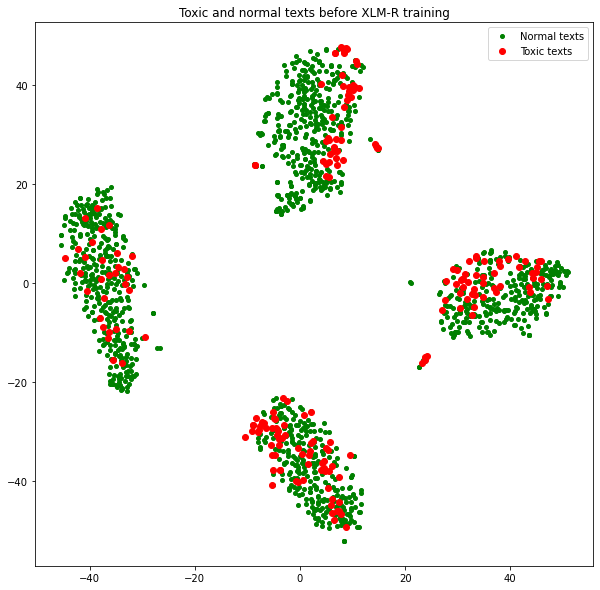

In [41]:
calculate_projections(data_for_cls_training, 'before XLM-R training')

I delete all data which becomes unnecessary and call the garbage collector.

In [42]:
del data_for_cls_training
gc.collect()

2620

I fix the duration of all procedures for data projecting.

In [43]:
projecting_duration = int(round(time.time() - preparing_end_time))
print("Duration of data projection is {0} seconds.".format(projecting_duration))

Duration of data projection is 160 seconds.


Lastly, I train my Siamese XLM-R.

Maximal duration of the Siamese XLM-R training is 6828 seconds.
Epoch 1/196
620/620 [==============================] - ETA: 0s - loss: 0.7777
Epoch 00001: val_loss improved from inf to 0.78727, saving model to /kaggle/working/siamese_xlmr.h5
620/620 [==============================] - 596s 961ms/step - loss: 0.7777 - val_loss: 0.7873
Epoch 2/196
620/620 [==============================] - ETA: 0s - loss: 0.5558
Epoch 00002: val_loss did not improve from 0.78727
620/620 [==============================] - 589s 950ms/step - loss: 0.5558 - val_loss: 0.8315
Epoch 3/196
620/620 [==============================] - ETA: 0s - loss: 0.5483
Epoch 00003: val_loss improved from 0.78727 to 0.69639, saving model to /kaggle/working/siamese_xlmr.h5
620/620 [==============================] - 592s 955ms/step - loss: 0.5483 - val_loss: 0.6964
Epoch 4/196
620/620 [==============================] - ETA: 0s - loss: 0.5176
Epoch 00004: val_loss improved from 0.69639 to 0.63544, saving model to /kaggle/working/si

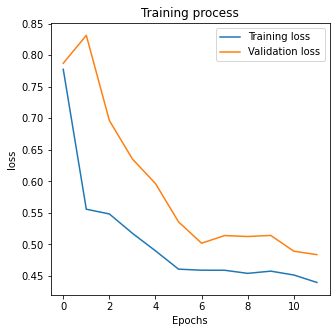

In [44]:
train_siamese_nn(nn=siamese_network, trainset=dataset_for_training,
                 steps_per_trainset=n_batches_per_data,
                 steps_per_epoch=steps_per_single_epoch,
                 validset=dataset_for_validation,
                 max_duration=int(round(
                     3600 * 2.5 - preparing_duration - 3.0 * projecting_duration
                 )),
                 model_weights_path=tmp_roberta_name)

I delete all data which becomes unnecessary and call the garbage collector.

In [45]:
del dataset_for_training
del dataset_for_validation
gc.collect()

2919

I load the best weights of XLM-R, found during the training process, from the HDF5 binary data file.

In [46]:
siamese_network.load_weights(tmp_roberta_name)
os.remove(tmp_roberta_name)
feature_extractor.save_weights(feature_extractor_name)

I delete the Siamese XLM-R (but not the XLM-R-based feature extractor!), and after that, I call the garbage collector.

In [47]:
del siamese_network
gc.collect()

5879

I calculate the featured training set for the final classifier using a trained XLM-R-based feature extractor.

In [48]:
dataset_for_training_ = calculate_features_of_texts(
    texts=multilingual_corpus,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    fe=feature_extractor,
    batch_size=batch_size_for_siamese
)
assert len(dataset_for_training_) == 4

Number of languages is 4.

Language "en": featurizing is started.
Number of texts is 3000.




3 examples of texts after tokenization:
  " ... -rather than rich, white and elite suburbanites at their rich, white and elite country clubs, drinking their rich, elite 75 dollar a glass scotch, with their pinky in the air congratulating themselves on caring about people."
That sounds more like the bishops and the K of C to me than the Democrats, who are busy trying to help people retain their right to vote.
  [0, 44, 153, 20, 43257, 3501, 98870, 6, 4, 35011, 136, 100307, 165473, 761, 52164, 99, 2363, 98870, 6, 4, 35011, 136, 100307, 23295, 117406, 6, 4, 23417, 214, 2363, 98870, 6, 4, 100307, 4948, 15437, 10, 47589, 14753, 18, 206, 6, 4, 678, 2363, 77233, 53, 23, 70, 1831, 242799, 1916, 61261, 98, 2258, 214, 1672, 3395, 6, 1242, 9925, 102678, 1286, 1884, 70, 333, 10534, 7, 136, 70, 341, 111, 313, 47, 163, 3501, 70, 138235, 7, 6, 4, 2750, 621, 86352, 31577, 47, 4358, 3395, 112033, 73, 2363, 7108, 47, 43374, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 



3 examples of texts after tokenization:
  Hola De verdad pensaste, que no te iba a encontrar?, te lo dije, te estoy rastreando, estoy rastreando tus comentarios, tus insultos y tus lloriqueos, pronto sabrás de mi.
  [0, 47958, 262, 36370, 14946, 824, 6, 4, 41, 110, 120, 7824, 10, 15275, 705, 4, 120, 459, 44123, 6, 4, 120, 43250, 8737, 107, 3448, 6, 4, 43250, 8737, 107, 3448, 15875, 69287, 6, 4, 15875, 100567, 232, 113, 15875, 115219, 75087, 232, 6, 4, 33895, 29033, 26579, 8, 324, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  Hola a todos: ¿No os parece que la frase que dice que el Gobierno de Zapatero está bajo crítica de que ha violado la Constitución española con sus nuevas leyes orgánicas, además de español indio, es muy partidista? Primero, que no viene a cuento en este artículo, y segundo, que 



3 examples of texts after tokenization:
  Beh, ammetto che ne passa di differenza tra una TT F1 e una CRT, ma entrambe sono motociclette con ciclistica da prototipo e motore di serie profondamente elaborato. Io mi riferivo a questo e volevo far notare la non-novità del concetto alla base delle CRT. Micap (msg)
  [0, 32208, 6, 4, 444, 1928, 188, 290, 108, 10434, 45, 101209, 1152, 220, 62497, 563, 418, 28, 220, 313, 20503, 6, 4, 291, 228488, 1389, 17498, 84229, 36711, 158, 6, 113880, 50482, 48, 147112, 31, 28, 2926, 13, 45, 6432, 39100, 4823, 121151, 31, 6, 5, 28136, 324, 66360, 56, 5777, 10, 3027, 28, 39898, 965, 2060, 110, 7696, 21, 351, 20, 92828, 146, 185947, 986, 3647, 1864, 313, 20503, 6, 5, 1208, 15644, 15, 68163, 177, 1388, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  non dovevi cancellare quello che avevo scritto su Jakidale perché è un grande e deve esserci anche lui nella



3 examples of texts after tokenization:
  Rica ederim, ne demek... Küçük yeşil domuzcuk için yaptım biraz da ... (Okumadım ama izledim. Oyun olarak, bu sezonun iyilerinden biriydi.) İyivikiler...    ho?       ni!
  [0, 92051, 68612, 6, 4, 108, 67746, 153, 117545, 142051, 54, 31558, 1010, 92, 1099, 38837, 39, 35304, 48, 153, 15, 81370, 143724, 2527, 35151, 5771, 6, 5, 38802, 2086, 6, 4, 373, 47238, 19, 5801, 18475, 7479, 16715, 6, 5, 16, 64414, 5342, 34759, 153, 739, 705, 300, 711, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  45x45px|left Vikipedi kurallarına aykırı hareketleriniz nedeniyle, değişiklik yapmanıza bir süre için izin verilmiyor. Eğer yararlı katkılarda bulunmak isterseniz, engellenme sürenizin sonunda tekrar geri gelebilirsiniz. Mskyrider   ileti
  [0, 2678, 425, 4633, 88684, 6, 587

Also, I calculate the featured data set, which will be used to submit predictions to the competition using some final classifier, trained on the abovementioned featured training set.

In [49]:
dataset_for_submission_ = calculate_features_of_texts(
    texts=texts_for_submission,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    fe=feature_extractor,
    batch_size=batch_size_for_siamese
)

Number of languages is 6.

Language "es": featurizing is started.
Number of texts is 8438.




3 examples of texts after tokenization:
  Usted es el vandalo aquí con las imagenes que pone incitadoras por muy 1950 que haya sido. El logo no está permitido y el  texto explicativo  no es más que un vulgar copyvio. Lea por favor WP:PVN antes de volver a contribuir. Nueva
  [0, 345, 14437, 198, 88, 131, 88359, 9877, 158, 576, 53657, 90, 41, 34387, 23, 30483, 48174, 196, 3591, 27631, 41, 13860, 8431, 6, 5, 540, 7643, 110, 1570, 164442, 113, 88, 18946, 14149, 5600, 110, 198, 1005, 41, 51, 129474, 43658, 10023, 6, 5, 54642, 196, 10862, 100568, 152, 436, 40711, 6361, 8, 43665, 10, 86786, 6, 5, 111191, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  «Michael Jackson and NSYNC» (colaboración de Jackson con N*Sync en los premios MTV VMA 2001). «Michael Jackson se inspira en Justin Timberlake y Usher» (Jackson hablando de su futuro ál



3 examples of texts after tokenization:
  Pourquoi avez vous supprimé  C est dur d être aimé par des cons  ? Parce que les culs bénis extrémistes (de toute religion) doivent faire la loi ? Cette phrase ne concernait que les    intégristes   , comme l avait bien indiqué Charlie Hebdo d ailleurs, et c est bien ce que j avais écrit, de façon me semble-t-il modérée. Et elle a été supprimée avant même que j’y ai ajouté la référence à l’article blasphème, qui faisait lui-même référence à cette citation entre crochets pour créer une page en attente, que je me suis donc empressé de compléter, ayant cette page de Charlie sous les yeux. colton (d)
  [0, 104552, 19116, 1023, 15811, 35188, 446, 313, 437, 7920, 104, 4385, 149028, 366, 224, 158, 7, 705, 112635, 41, 199, 57940, 7, 5671, 2706, 101730, 21460, 15, 8, 13725, 42615, 1388, 60652, 2973, 21, 37135, 705, 20097, 113860, 108, 50509, 9898, 41, 199, 6, 119081, 21460, 6, 4, 3739, 96, 17095, 1806, 149841, 71305, 30488, 246, 104, 97867, 6, 4, 82, 



3 examples of texts after tokenization:
  , ma sarebbe anche da aggiungere l obbligo di contattare il/i progetto/i di riferimento per la valutazione, allo stesso modo di quanto previsto per le cancellazioni (ciò risolve il problema di trovare valutatori competenti senza bisogno di contattare in talk utenti particolari, evitando il rischio di campagne selettive). Franz van Lanzee (msg)
  [0, 6, 4, 291, 38147, 1968, 48, 138692, 96, 6, 172294, 45, 96108, 107, 211, 248, 17, 25117, 248, 17, 45, 56610, 117, 21, 122289, 6, 4, 24286, 19053, 3792, 45, 7045, 35948, 117, 95, 126136, 2813, 15, 29195, 1427, 86918, 211, 4105, 45, 34315, 53258, 3826, 6, 122103, 14, 7699, 46321, 45, 96108, 107, 23, 22120, 59083, 98283, 6, 4, 158543, 211, 67277, 45, 59679, 40, 1974, 4935, 6, 194, 86914, 131, 239, 25609, 13, 15, 68163, 177, 1388, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  ANTIPATICO!!! CHE NE SAI TU



3 examples of texts after tokenization:
  Olá Béria, na verdade a alteração que fiz na Página do Ex-Presidente Itamar Franco estava correta. Ele nasceu em Juiz de Fora e não em Salvador como diz lá. Talvez eu não tenha feito da forma correta, mas, de fato essa é a verdade. Eis uma fonte mais que confiável: http://www.presidencia.gov.br/info_historicas/galeria_pres/galitamar/galitamar/integrapresidente_view/ Obrigado. Um forte abraço. CH.
  [0, 91906, 335, 48488, 6, 4, 24, 31522, 10, 42068, 1156, 41, 17148, 24, 199618, 54, 5443, 20, 34824, 1650, 62851, 36160, 17047, 174442, 6, 5, 12701, 53948, 34, 352, 3314, 1418, 8, 1326, 11, 28, 1027, 352, 61356, 533, 21111, 5648, 6, 5, 195391, 1175, 1027, 46388, 22247, 48, 1483, 174442, 6, 4, 1163, 6, 4, 8, 40887, 11865, 393, 10, 31522, 6, 5, 104331, 788, 53235, 732, 41, 17438, 21299, 152, 1621, 6, 696, 1426, 6, 5, 215193, 6, 5, 6, 12074, 6, 5, 5491, 248, 3004, 454, 66029, 9381, 248, 155043, 454, 9518, 248, 4662, 102, 1727, 248, 4662, 102, 1727, 24



3 examples of texts after tokenization:
  Отвратительное оформление статьи: пример того, как они не должны оформляться. Три вида марок плюс какая-то монета - что они призваны проиллюстрировать? Текст теряется посреди этой филателической галиматьи.
  [0, 3858, 55251, 80502, 103, 213506, 47190, 152, 12049, 2574, 6, 4, 819, 2792, 77, 13995, 204006, 2454, 6, 5, 27874, 20999, 22775, 2297, 56756, 84933, 20, 690, 89405, 59, 20, 414, 2792, 182830, 227, 591, 89, 133247, 15782, 16833, 705, 56968, 238084, 989, 147173, 89, 10757, 44363, 59, 11892, 31825, 29415, 3532, 1117, 89, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  А может наоборот? «Везде» «знатоки» переводят с английского без понятия о том, что же было в японском?)) Ну а насчет смешно: а мне имена-названия смешными не кажутся — у каждого свое чувство юмора, может 



3 examples of texts after tokenization:
  Sayın Yalhı, Teşekkür ederim. Umarım silinmez. Bu yürüyüş parkuru hem tarihin yaşaması için önem arzediyor hemde yerel ekonomiye katkıda bulunarak köylerden kentlere göçü engelliyor. Köyde yaşayan insanların bulundukları yer ile gurur duymalarına vesile oluyor. Katkılarınızdan dolayı ayrıca teşekkür ederim. Selam ve sevgiler, Sedat Çakır Sedatcakir
  [0, 116371, 2369, 79366, 1057, 6, 4, 208262, 68612, 6, 5, 2793, 80592, 78, 2397, 11723, 6, 5, 667, 184161, 366, 120209, 2360, 33700, 19, 24654, 8390, 1099, 64780, 187, 64807, 18369, 2360, 112, 115406, 6046, 1033, 65990, 85, 53877, 13489, 69041, 18328, 24603, 6660, 138797, 3449, 161674, 13437, 6, 5, 21621, 53, 112, 41327, 37403, 42095, 84552, 4098, 1350, 13455, 42, 16969, 192, 7551, 35882, 133, 38479, 6, 5, 7291, 12558, 66798, 549, 50069, 60888, 47902, 68612, 6, 5, 503, 3719, 173, 53967, 603, 6, 4, 4246, 257, 6725, 344, 3772, 4246, 257, 408, 8372, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

I delete the XLM-R-based feature extractor and corresponded tokenizer. They are no longer needed.

In [50]:
del feature_extractor, xlmroberta_tokenizer

I simplify the abovementioned data for the final classifier training and submitting using this classifier. Simplification is realized by means of these data transforming from a dictionary by languages to a "normal" NumPy arrays pairs (X and y). Also, in this way, I get a CV splitting of training data.

In [51]:
data_for_cls_training, cv_splitting, submission_data_for_cls = generate_featured_data(
    dataset_for_training_,
    dataset_for_submission_
)

I delete all data which becomes unnecessary and call the garbage collector.

In [52]:
del dataset_for_training_, dataset_for_submission_
gc.collect()

88

I show projections of data, which are featured by a trained XLM-R.

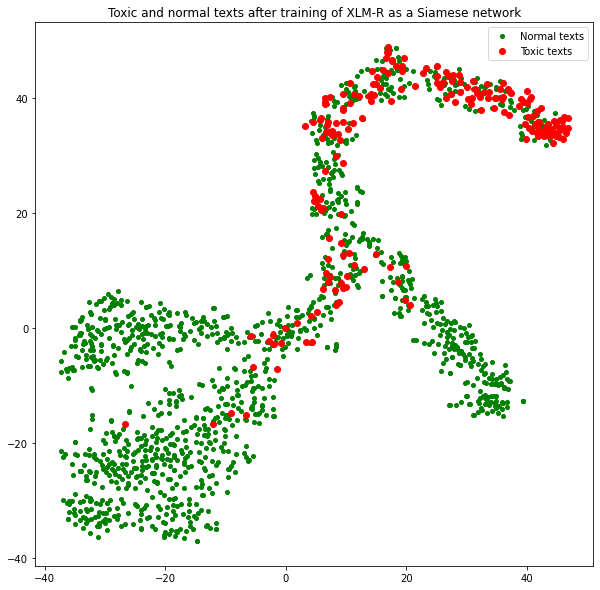

In [53]:
calculate_projections(data_for_cls_training, 'after training of XLM-R as a Siamese network')

At last, I save all featured data in the special binary file. After that, I can re-use these data in any experiment with the final classifier. The Siamese XLM-R is no longer needed because it had done its work!

In [54]:
with open(tmp_features_name, 'wb') as fp:
    pickle.dump(
        obj=(data_for_cls_training, cv_splitting, submission_data_for_cls),
        file=fp,
        protocol=pickle.HIGHEST_PROTOCOL
    )